In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

import sys 
sys.path.append("..")
sys.path.append("../src")

%load_ext autoreload
%autoreload 2

In [2]:
from src.functions import *
from src.Model import Model

## Framework for testing the noisy models

Todo
* Save to disk the results so I don't loose them
* Make function which takes a model and test data and then
  * Adds some noise to the model
  * Runs through the test data using the noisy model
  * Does this n times before adding more noise and repeat
  * Save the results on disk 
* Make function which plots the average result and standard deviation from test function

In [3]:
def testNoisePerformance(model: Model, data, noiseParameters, noiseType = "gaussian", averageCount = 10):
    accuracy = np.zeros((len(noiseParameters), averageCount))
    for i, (amount, param) in enumerate(noiseParameters):
        for ii in range(averageCount):
            model.addNoise(noiseType, amount, param)
            customName = "("+str(i*averageCount+ii+1)+"/"+str(averageCount*len(noiseParameters))+") - "+noiseType+" noise - "+str(amount)+", "+str(param)
            accuracy[i,ii] = np.mean(model.evaluateModel(data, customName))
            model.resetWeights()
    return accuracy

In [48]:
#np.random.seed(240705)
#np.random.seed(666)
np.random.seed(13)

name = "hist"
maxSequenceLength = 5
N = 500
model = generateModel(name, maxSequenceLength)
data = generateData(name, maxSequenceLength, N)

noiseParameters = [(1.,0.0002), (1., 0.0006), (1., 0.0010), (1., 0.0014), (1., 0.018), (1., 0.022), (1., 0.0026), 
                   (1., 0.0030), (1., 0.0034), (1., 0.0038), (1., 0.0042), (1., 0.0046), (1., 0.0050)]
accuracy = testNoisePerformance(model, data, noiseParameters, averageCount=11)

Evaluating model: (1/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (2/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (3/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (4/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (5/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (6/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (7/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (8/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (9/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (10/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (11/143) - gaussian noise - 1.0, 0.0002
Evaluating model: (12/143) - gaussian noise - 1.0, 0.0006
Evaluating model: (13/143) - gaussian noise - 1.0, 0.0006
Evaluating model: (14/143) - gaussian noise - 1.0, 0.0006
Evaluating model: (15/143) - gaussian noise - 1.0, 0.0006
Evaluating model: (16/143) - gaussian noise - 1.0, 0.0006
Evaluating model: (17/143) - gaussian noise - 1.0, 0.0006
Evaluating model: (18/1

In [49]:
print(accuracy)

savedAcc = accuracy.copy()

[[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.996 1.    1.    1.    0.84  0.988 1.    1.    1.    0.994 1.   ]
 [0.916 1.    0.656 0.976 0.81  0.96  0.908 0.96  0.96  1.    0.392]
 [0.002 0.014 0.07  0.002 0.    0.106 0.068 0.014 0.054 0.002 0.018]
 [0.002 0.012 0.    0.026 0.022 0.008 0.002 0.002 0.006 0.002 0.024]
 [0.572 0.864 0.978 0.9   0.218 0.674 0.988 0.672 0.692 0.894 0.576]
 [0.726 0.93  0.29  0.41  0.466 0.496 0.936 0.616 0.562 0.044 0.254]
 [0.624 0.608 0.766 0.456 0.6   0.174 0.832 0.66  0.262 0.222 0.864]
 [0.39  0.142 0.614 0.378 0.214 0.95  0.14  0.29  0.24  0.098 0.924]
 [0.45  0.144 0.67  0.46  0.508 0.216 0.618 0.02  0.594 0.072 0.206]
 [0.022 0.274 0.274 0.444 0.292 0.21  0.486 0.088 0.01  0.046 0.062]
 [0.226 0.062 0.31  0.    0.128 0.426 0.312 0.386 0.098 0.236 0.708]]


In [50]:
def saveAccuracy(accuracy, fileName="temp"):
    file = open("savedData/"+fileName, "wb")
    np.save(file, accuracy)
    file.close()

saveAccuracy(accuracy, "hist_13from0.0002-0.05_11avg_v3")

In [51]:
def loadAccuracy(fileNames="temp"):
    if type(fileNames) is list:
        file = open("savedData/"+fileNames[0], "rb")
        accuracy = np.load(file)
        file.close()
        for fn in fileNames[1:]:
            file = open("savedData/"+fn, "rb")
            conAcc = np.load(file)
            accuracy = np.concatenate((accuracy, conAcc), axis=1)
            file.close()
        
    else:
        file = open("savedData/"+fileNames, "rb")
        accuracy = np.load(file)
        file.close()
    return accuracy

acc = loadAccuracy()

print(acc)

[[0.06 0.14 0.3  0.87 0.04 0.78 1.  ]
 [0.77 0.24 0.21 0.04 0.05 0.35 0.01]
 [0.01 0.14 0.02 0.15 0.33 0.44 0.17]
 [0.07 0.03 0.01 0.05 0.19 0.02 0.25]
 [0.02 0.07 0.06 0.04 0.   0.1  0.4 ]]


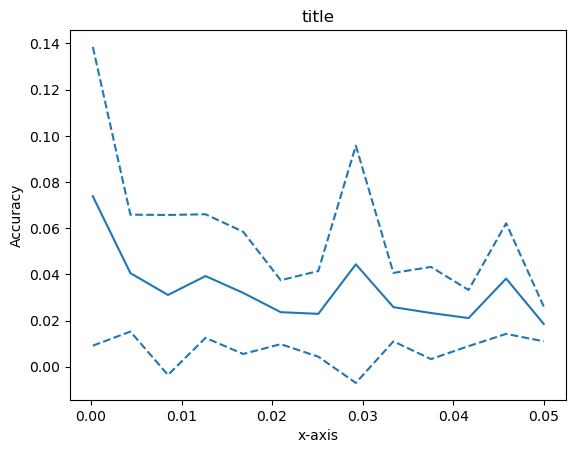

In [47]:
def plotAccuracy(accuracy, xaxis, title="title", xlabel="x-axis"):
    mean = np.mean(accuracy, axis=1)
    std = np.std(accuracy, axis=1)
    plt.figure()
    plt.plot(xaxis, mean, color="#1f77b4")     #Plot mean
    plt.plot(xaxis, mean+std, color="#1f77b4", linestyle="--") #Plot std
    plt.plot(xaxis, mean-std, color="#1f77b4", linestyle="--") #Plot std
    plt.ylabel("Accuracy")
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

plotAccuracy(accuracy, np.linspace(0.0002, 0.05, 13))

### Ploting some saved results

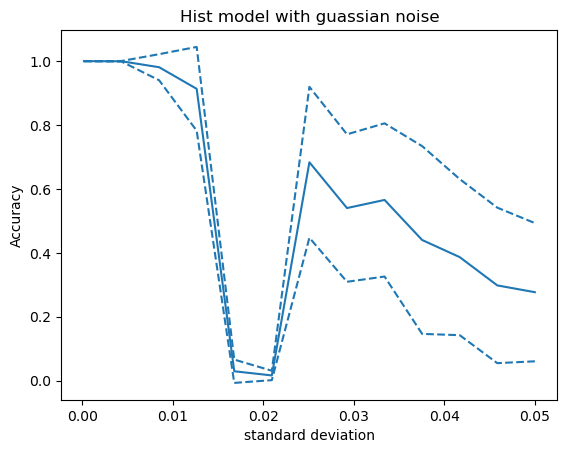

In [54]:
#Load and display hist data
acc = loadAccuracy(["hist_13from0.0002-0.05_11avg","hist_13from0.0002-0.05_11avg_v2","hist_13from0.0002-0.05_11avg_v3"])
plotAccuracy(acc, np.linspace(0.0002, 0.05, 13), "Hist model with guassian noise", "standard deviation")

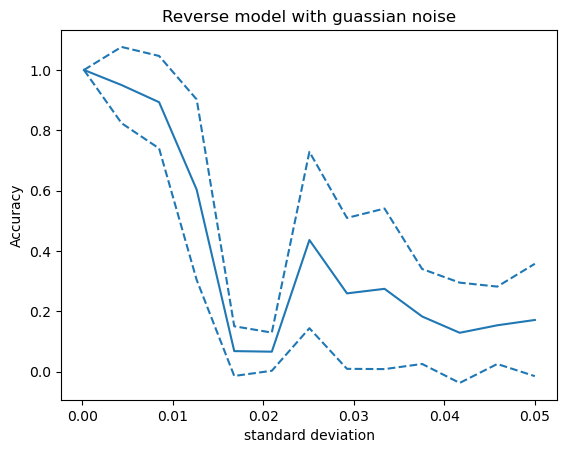

In [55]:
#Load and display reverse data
acc = loadAccuracy(["reverse_13from0.0002-0.05_11avg","reverse_13from0.0002-0.05_11avg_v2"])
plotAccuracy(acc, np.linspace(0.0002, 0.05, 13), "Reverse model with guassian noise", "standard deviation")

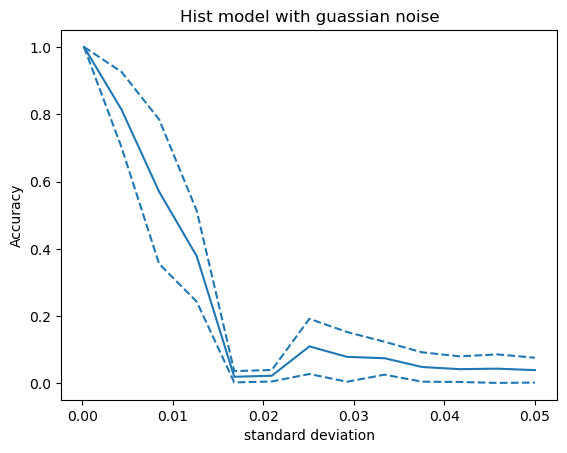

In [56]:
#Load and display sort data
acc = loadAccuracy(["sort_13from0.0002-0.05_11avg","sort_13from0.0002-0.05_11avg_v2"])
plotAccuracy(acc, np.linspace(0.0002, 0.05, 13), "Hist model with guassian noise", "standard deviation")

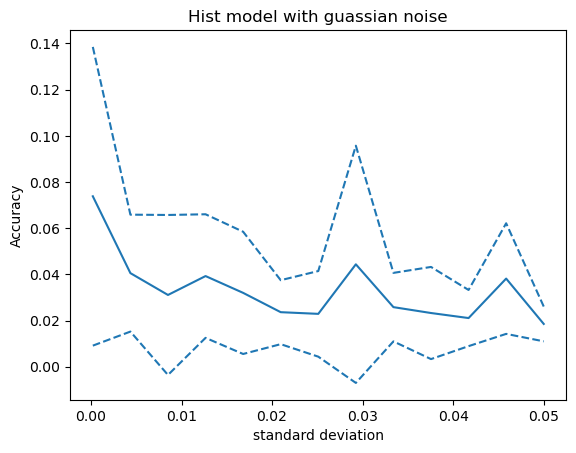

In [58]:
#Load and display most-freq data
acc = loadAccuracy("most-freq_13from0.0002-0.05_11avg")
plotAccuracy(acc, np.linspace(0.0002, 0.05, 13), "Hist model with guassian noise", "standard deviation")

The result for reverse (and sort) has a strange lowpoint at 0.02 ish

So far all my results are with max sequence length 5